# Assignment 3

## Import Libraries

In [2]:
# import all necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.inspection import permutation_importance
import shap

## Implementations

In [3]:
# Q1. Load dataset
# *** Write your code here to load the dataset ***

df_german_credit = pd.read_csv("german_credit.csv")

print(df_german_credit.head())

  existing_account  duration credit_history purpose  amount savings  \
0              A11         6            A34     A43    1169     A65   
1              A12        48            A32     A43    5951     A61   
2              A14        12            A34     A46    2096     A61   
3              A11        42            A32     A42    7882     A61   
4              A11        24            A33     A40    4870     A61   

  employment_since  disposable_income_rate gender_status other_debtors  ...  \
0              A75                       4           A93          A101  ...   
1              A73                       2           A92          A101  ...   
2              A74                       2           A93          A101  ...   
3              A74                       2           A93          A103  ...   
4              A73                       3           A93          A101  ...   

   property age  installment_plans housing n_existing_credit   job  \
0      A121  67             

In [4]:
# Q2. Split gender_status into gender and marital_status
# *** Write your code here to split 'gender_status' ***

# from the table
gender_map = {
    "A91": ("male", "divorced/separated"),
    "A92": ("female", "divorced/separated/married"),
    "A93": ("male", "single"),
    "A94": ("male", "married/widowed"),
    "A95": ("female", "single"),
}

df_german_credit[["gender", "marital_status"]] = df_german_credit["gender_status"].map(gender_map).apply(pd.Series)

print(df_german_credit[["gender_status", "gender", "marital_status"]].head())

  gender_status  gender              marital_status
0           A93    male                      single
1           A92  female  divorced/separated/married
2           A93    male                      single
3           A93    male                      single
4           A93    male                      single


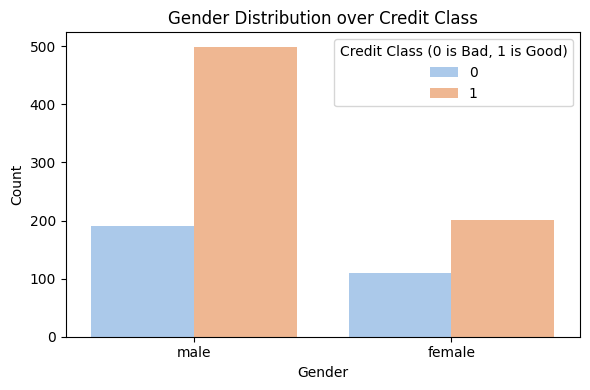

In [5]:
# Q3. Plot gender distribution over credit classes
# *** Write your code here to generate the plot ***

plt.figure(figsize=(6, 4))
sns.countplot(data=df_german_credit, x="gender", hue="class", palette="pastel")
plt.title("Gender Distribution over Credit Class")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Credit Class (0 is Bad, 1 is Good)")
plt.tight_layout()
plt.show()

In [6]:
# Q4. Rename columns and values for clarity
# *** Write your code here to rename values and columns ***

account_map = {
    "A11": "lt_0",
    "A12": "btw_0_200",
    "A13": "gte_200",
    "A14": "no_account"
}

df_german_credit["existing_account"] = df_german_credit["existing_account"].map(account_map)

print(df_german_credit[["existing_account"]].head())

  existing_account
0             lt_0
1        btw_0_200
2       no_account
3             lt_0
4             lt_0


In [7]:
# Q5. Encode categorical features
# *** Write your code here to encode categorical features ***

df_german_credit.drop(columns=['gender_status'], inplace=True)

cat_cols = [
    "existing_account", "credit_history", "purpose", "savings", "employment_since",
    "gender", "marital_status", "other_debtors", "property", "installment_plans",
    "housing", "job", "telephone", "foreign_worker"
]

df_encoded = pd.get_dummies(df_german_credit, columns=cat_cols, drop_first=True)

print(df_encoded.head())

   duration  amount  disposable_income_rate  residence_since  age  \
0         6    1169                       4                4   67   
1        48    5951                       2                2   22   
2        12    2096                       2                3   49   
3        42    7882                       2                4   45   
4        24    4870                       3                4   53   

   n_existing_credit  n_liable_people  class  existing_account_gte_200  \
0                  2                0      1                     False   
1                  1                0      0                     False   
2                  1                1      1                     False   
3                  1                1      1                     False   
4                  2                1      0                     False   

   existing_account_lt_0  ...  property_A124  installment_plans_A142  \
0                   True  ...          False                   False

In [8]:
# Q6. Train Decision Tree with tuning
# *** Write your code here to train and evaluate a decision tree ***

X = df_encoded.drop(columns=["class"])
y = df_encoded["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_tree = grid.best_estimator_
print("Best params:", grid.best_params_)

y_pred = best_tree.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("F1 Score:", f1, "Acc:", accuracy)

Best params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
F1 Score: 0.8228228228228228 Acc: 0.705


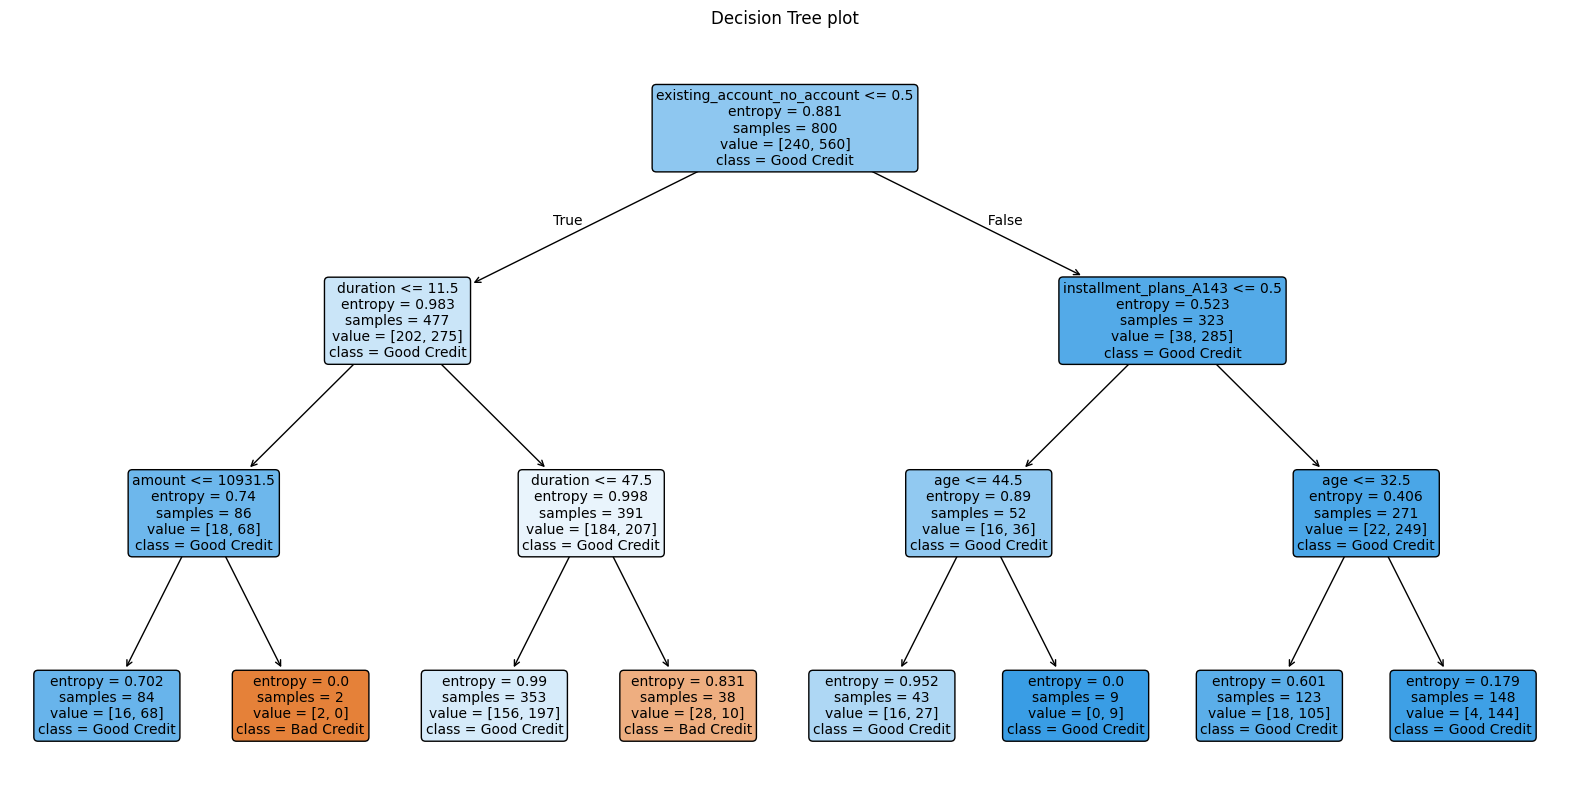

In [9]:
# Q7. Plot Decision Tree
# *** Write your code here to visualize the decision tree ***

plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=X.columns,
    class_names=["Bad Credit", "Good Credit"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree plot")
plt.show()

In [21]:
# Q8. Train Random Forest with tuning
# *** Write your code here to train and evaluate a random forest ***
rf_param_grid = {
    "n_estimators": [100, 200, 300], 
    "max_depth": [5, 10, None], 
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "criterion": ["gini", "entropy"],
}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=2), param_grid=rf_param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)

rf_grid_search.fit(X_train, y_train)

best_rf = rf_grid_search.best_estimator_
print("Best parameters: " + str(rf_grid_search.best_params_))

y_pred_rf = best_rf.predict(X_test)

f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Random F1 Score: " + str(f1_rf))
print("Random Accuracy: " + str(accuracy_rf))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Random F1 Score: 0.8387096774193549
Random Accuracy: 0.75


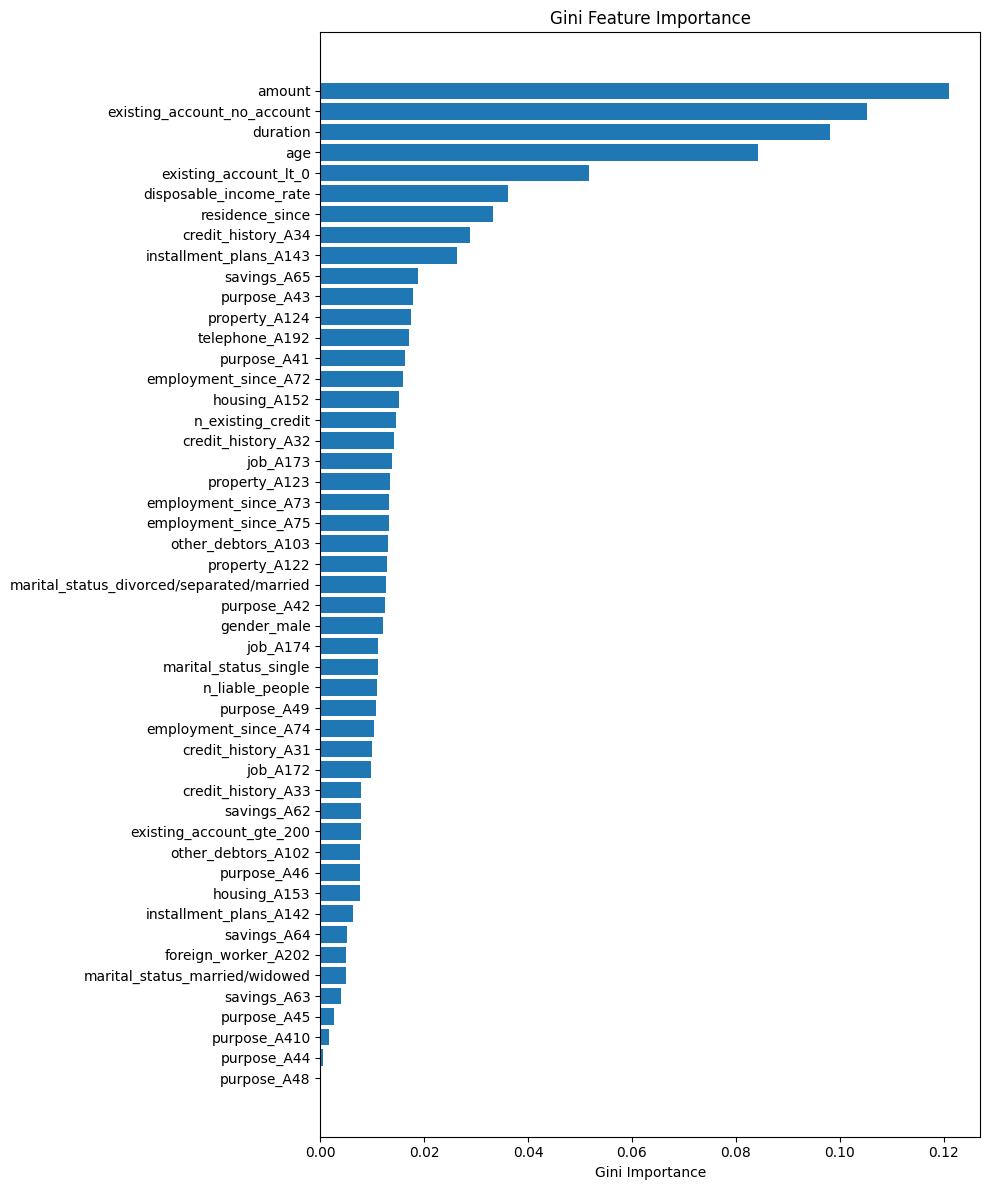

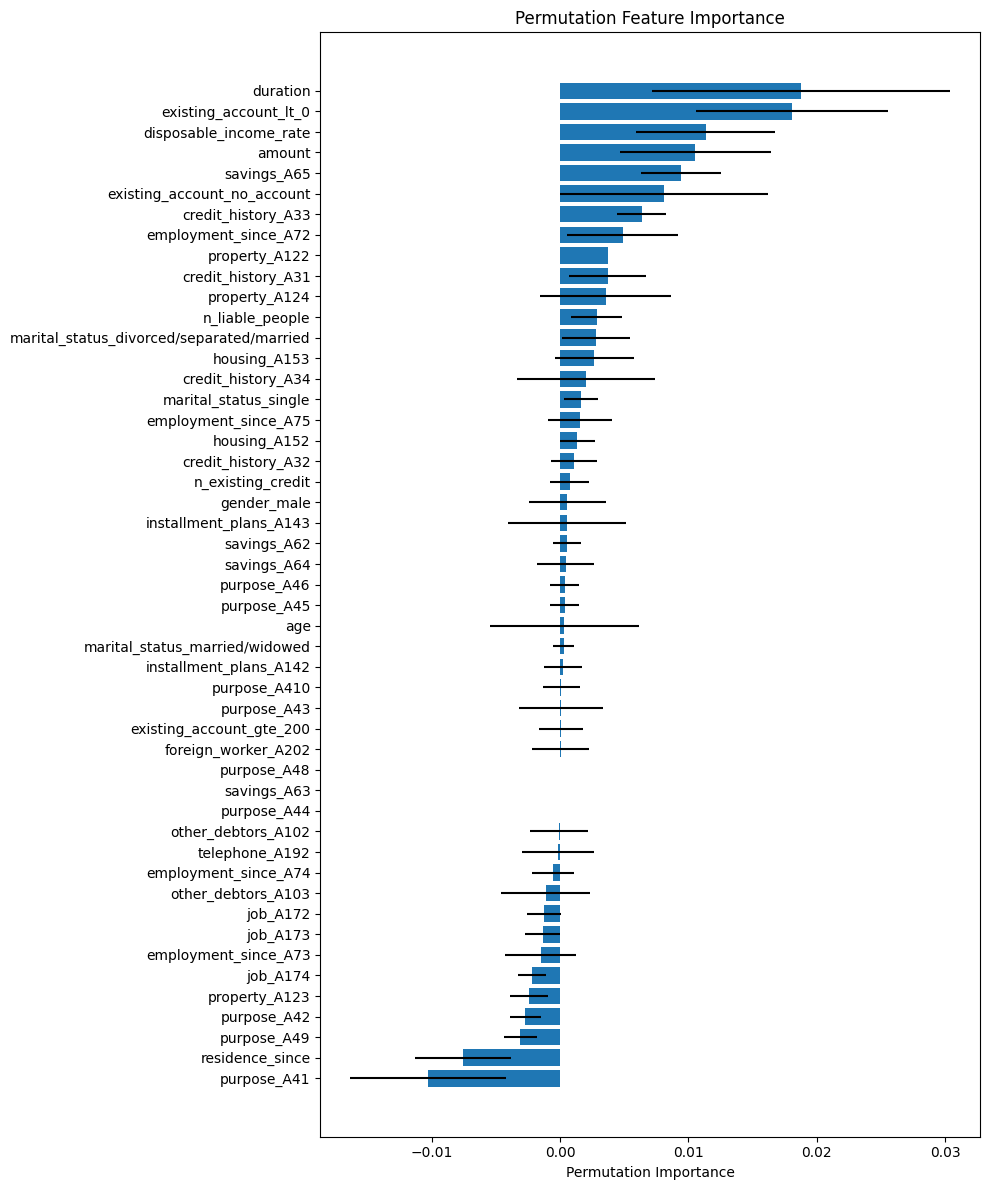

In [ ]:
# Q9. Feature importance comparison: Gini vs Permutation
# *** Write your code here to compute and compare importances ***
gini_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns)
sorted_gini = gini_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(sorted_gini.index, sorted_gini.values)
plt.title("Gini Feature Importance")
plt.xlabel("Gini Importance")
plt.tight_layout()
plt.show()

permutation_importance = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=2, scoring="f1", n_jobs=-1)

permutation_importances = pd.DataFrame({
        "feature": X_test.columns,
        "importance_mean": permutation_importance.importances_mean,
        "importance_std": permutation_importance.importances_std,
    }
)
sorted_perm = permutation_importances.sort_values(by="importance_mean", ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(sorted_perm["feature"], sorted_perm["importance_mean"], xerr=sorted_perm["importance_std"])
plt.title("Permutation Feature Importance")
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

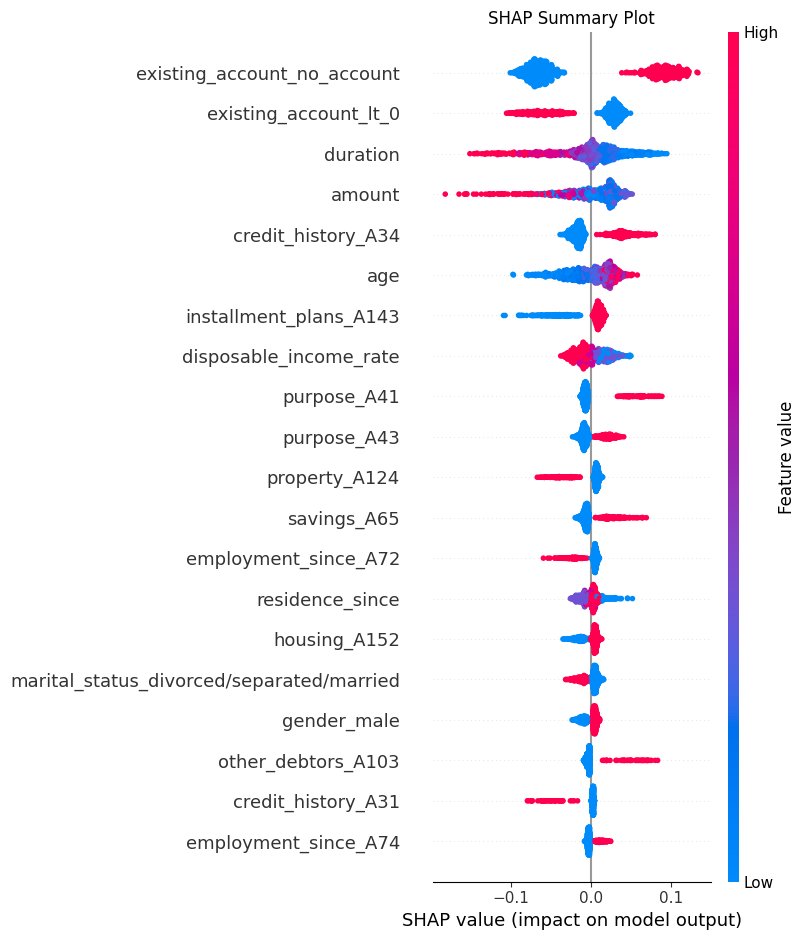

In [20]:
# Q10. SHAP global explanation
# *** Write your code here to plot SHAP summary ***
explainer = shap.TreeExplainer(best_rf)
shap_explanation = explainer(X)
plt.title("SHAP Summary Plot")
# We use a summary plot to show shap valuues for the entire dataset
shap.summary_plot(shap_explanation[:, :, 1], show=False)

In [ ]:
# Q11. SHAP local explanation
# *** Write your code here to generate SHAP force plot for the first instance ***
shap.initjs() # Need to import to use force plot in Notebook
first_instance_explanation = shap_explanation[0, :, 1] # Get the first instance of the dataset
shap.force_plot(first_instance_explanation)

Displaying SHAP Force Plot for the first instance:
